# Feature Selection Notebook (nyi malik et nour)

Use this template notebook to try a FeatureExtractor and test it on different simple models.

In [6]:
from problem import get_train_data, get_test_data,load_ascad
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

In [10]:
# Loading data
#X, y = get_train_data()
db = load_ascad("data/ASCAD.h5",True)[2]

In [23]:
db[1][253]["key"]

array([ 77, 251, 224, 242, 114,  33, 254,  16, 167, 141,  74, 220, 142,
        73,   4, 105], dtype=uint8)

## Little bit of EDA before we craft some features

In [18]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def get_stat_vectors(X, y):
    '''Computes the mean, variance, and std feature vector corresponding to each label'''
    mean_vectors = []
    var_vectors  = []
    std_vectors  = []
    
    for label in range(256):
        mean_vector = X[y==label].mean(axis=0)
        mean_vectors.append(mean_vector)
        
        var_vector = X[y==label].var(axis=0)
        var_vectors.append(var_vector)
        
        std_vector = X[y==label].std(axis=0)
        std_vectors.append(std_vector)

def get_mean_vectors(X, y):
    '''Computes the mean, variance, and std feature vector corresponding to each label'''
    mean_vectors = []
    var_vectors  = []
    std_vectors  = []
    
    for label in range(256):
        mean_vector = X[y==label].mean(axis=0)
        mean_vectors.append(mean_vector)
        
    return np.array(mean_vectors)

def get_sum(v, metric='euclidean'):
    return pairwise_distances(v, metric=metric).sum(axis=0)

In [184]:
# We compute mean label vectors
mean_vectors = get_mean_vectors(X, y)

In [185]:
mean_vectors.shape

(256, 700)

In [186]:
var = mean_vectors.var(axis=0)
print(var.shape)

(700,)


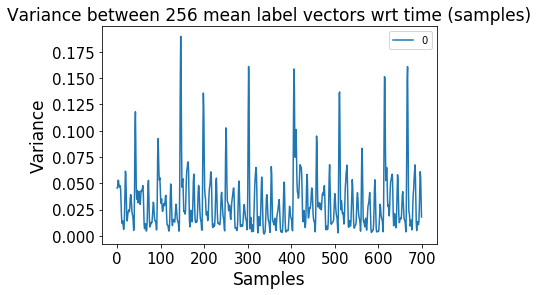

In [213]:
plt.figure(figsize=(20,10))
df_var = pd.DataFrame(var)
df_var.plot()
plt.title("Variance between 256 mean label vectors wrt time (samples)",fontsize=17)
plt.xlabel("Samples",fontsize=17)
plt.xticks(fontsize=15, visible=True)
plt.ylabel("Variance",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

In [192]:
# Getting the indices where the variance is the highest
np.argpartition(X.var(axis=0), -6)[-6:]

694    145
695    667
696    302
697    147
698    406
699    146
dtype: int64

In [198]:
# We reduce the data around some of the peak variance areas
peaks_indices = [145, 667, 302, 406]
new_X = np.concatenate([X.values[:,i-5:i+5] for i in peaks_indices], axis=1)
#scaler = StandardScaler()
#new_X_scaled = scaler.fit_transform(new_X, y)

[ 38  47  38  18 100]


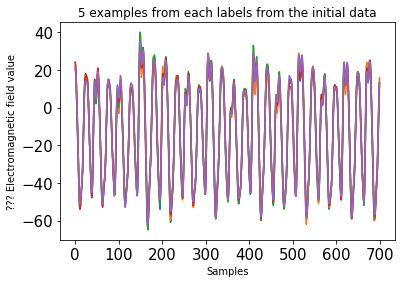

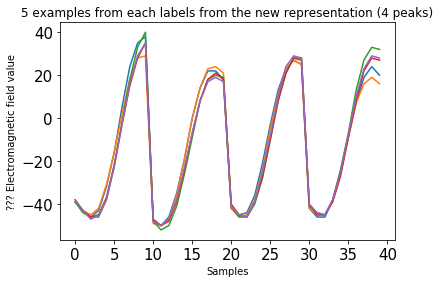

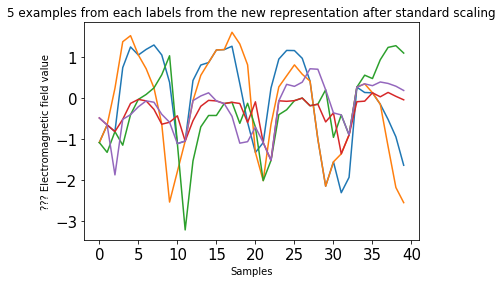

In [218]:
import warnings
warnings.filterwarnings('ignore')


for i in range(5):
    plt.plot([i for i in range(700)], X.values[i])
plt.title("5 examples from from the initial data")
plt.xlabel("Samples")
plt.xticks(fontsize=15, visible=True)
plt.ylabel("??? Electromagnetic field value")
plt.yticks(fontsize=15)
plt.show()

for i in range(5): 
    plt.plot([i for i in range(40)], new_X[i])
plt.title("5 examples from the new representation (4 peaks)")
plt.xlabel("Samples")
plt.xticks(fontsize=15, visible=True)
plt.ylabel("??? Electromagnetic field value")
plt.yticks(fontsize=15)
plt.show()


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(new_X, y)
new_X_scaled = scaler.transform(new_X)
for i in range(5): 
    plt.plot([i for i in range(40)], new_X_scaled[i])
plt.title("5 examples after standard scaling")
plt.xlabel("Samples")
plt.xticks(fontsize=15, visible=True)
plt.ylabel("??? Electromagnetic field value")
plt.yticks(fontsize=15)
plt.show()

For our baseline we will use those informations and create a representation focused around 4 variance peak points.


## Now we code a FeatureExtractor and a Classifier

In [219]:
# We reload the data just in case 
X, y = get_train_data()

In [220]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False
        self.mean_vectors = None
        self.n = 40
        self.pca = PCA(n_components=self.n)
        # Indices for which we observed high variance in the data 
        self.peaks_indices = [145, 667, 302, 406]


    def fit(self, X, y):
        new_X = X.copy()
        self.y = y
        #self.mean_vectors = get_mean_vectors(new_X, y)
        #self.pca.fit(X, y)
        print('FeatureExtractor debug : Fitted (mean-v and pca)')
        return self

    def transform(self, X):
        new_X = X.copy()
        new_X = np.concatenate([new_X.values[:,i-5:i+5] for i in self.peaks_indices], axis=1)
        print(new_X.shape)
        if not self.fitted:
            self.mean_vectors = get_mean_vectors(new_X, self.y)
            self.fitted = True
        #pca_X = self.pca.transform(new_X)
        #new_X = pca_X
        dist_X = np.abs(pairwise_distances(new_X, self.mean_vectors, metric='euclidean'))
        new_X = np.concatenate((new_X, dist_X), axis=1)
        #new_X = np.concatenate((new_X, pca_X), axis=1)
        print('FeatureExtractor debug : new X shape : '+str(new_X.shape))
        return new_X

def get_mean_vectors(X, y):
    print('FeatureExtractor debug : calling get_mean_vectors')
    mean_vectors = []
    
    for label in range(256):
        mean_vector = X[y==label].mean(axis=0)
        mean_vectors.append(mean_vector)
    
    return np.array(mean_vectors)

def get_sum(v, metric='euclidean'):
    print('FeatureExtractor debug : calling get_sum')
    return pairwise_distances(v, metric=metric).sum(axis=0)

FeatureExtractor debug : Fitted (mean-v and pca)
(50000, 40)
FeatureExtractor debug : calling get_mean_vectors
FeatureExtractor debug : new X shape : (50000, 296)


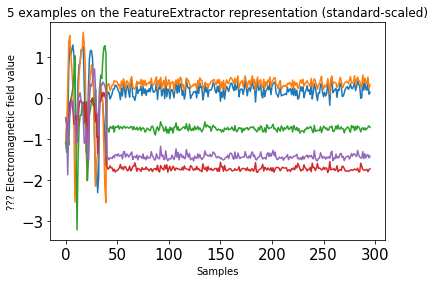

In [237]:
tr = FeatureExtractor()
XX = tr.fit_transform(X, y)
scaler = StandardScaler()
XX_std = scaler.fit_transform(XX, y)

for i in range(5): 
    plt.plot([i for i in range(296)], XX_std[i])
plt.title("5 examples on the FeatureExtractor representation (standard-scaled)")
plt.xlabel("Samples")
plt.xticks(fontsize=15, visible=True)
plt.ylabel("??? Electromagnetic field value")
plt.yticks(fontsize=15)
plt.show()

In [158]:
from sklearn.base import BaseEstimator
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

class Classifier(BaseEstimator):
    def __init__(self):
        #self.clf = LogisticRegression(random_state=0, solver='lbfgs')
        #self.clf = make_pipeline(StandardScaler(), LogisticRegression(verbose=1))
        #self.clf = make_pipeline(StandardScaler(), GaussianNB())
        
        #self.clf = CatBoostClassifier(iterations=15, depth=4, learning_rate=1,verbose=True)
        #self.clf = make_pipeline(StandardScaler(),SVC(C=100, verbose=True, kernel='rbf', probability=True))
        #self.clf = KNeighborsClassifier()
        
        #self.clf = SGDClassifier(max_iter=30, verbose=1, loss='log')
        #self.rbf = RBFSampler(gamma=0.001, random_state=1)
        
        #self.clf = GaussianNB()
        
    def fit(self, X, y):
        #self.rbf.fit_transform(X)
        #print('RBF fitted')
        self.clf.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        y_pred_proba = self.clf.predict_proba(X)
        return y_pred_proba


In [104]:
from sklearn.base import BaseEstimator
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.svm import LinearSVC

import numpy as np

class Classifier(BaseEstimator):
    def __init__(self):
        self.epochs=50
        self.batch_size=100
        self.nodes = 200
        self.model = Sequential()
        self.model.add(Dense(self.nodes, input_dim=296, activation='relu'))
        self.model.add(Dense(256, activation='softmax'))
        #self.optimizer = RMSprop(lr=0.00001)
        self.optimizer = RMSprop(lr=0.001)
        self.model.compile(loss='categorical_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.clf = self.model
    def fit(self, X, y):
        self.clf.fit(X, y=to_categorical(y, num_classes=256), batch_size=self.batch_size, verbose = 1, epochs=self.epochs)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        y_pred_proba = self.clf.predict_proba(X)
        return y_pred_proba


# Testing

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from problem import AUTR

In [160]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [161]:
model = make_pipeline(FeatureExtractor(), Classifier())

In [162]:
%time model.fit(X_train, y_train)

FeatureExtractor debug : Fitted (mean-v and pca)
(35000, 40)
FeatureExtractor debug : calling get_mean_vectors
FeatureExtractor debug : new X shape : (35000, 296)
CPU times: user 1.53 s, sys: 180 ms, total: 1.71 s
Wall time: 1.66 s


Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [163]:
%time predictions = model.predict_proba(X_valid)

(15000, 40)
FeatureExtractor debug : new X shape : (15000, 296)
CPU times: user 15.2 s, sys: 1.63 s, total: 16.8 s
Wall time: 8.98 s


In [164]:
scorer = AUTR()
print("Area Under The Rank : "+str(scorer(y_valid, predictions)))

/Users/nour/Desktop/AIC/datacamp/sca_challenge/problem.py:185: RuntimeWarning: divide by zero encountered in log
  key_bytes_proba[i] += np.log(min_proba**2)


Area Under The Rank : 0.1735625


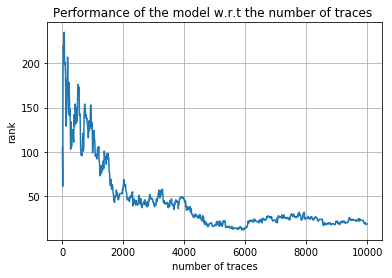

In [165]:
ranks = scorer.rankings

x = [ranks[i][0] for i in range(0, ranks.shape[0])]
y = [ranks[i][1] for i in range(0, ranks.shape[0])]
plt.title('Performance of the model w.r.t the number of traces ')
plt.xlabel('number of traces')
plt.ylabel('rank')
plt.grid(True)
plt.plot(x, y)
plt.show()
plt.figure()


NB 0.44783203125

NB FT Noured 0.3904609375

MLP ST2 Noured 0.55234765625

NB Noured + Dist 0.1735625


In [ ]:

x = [ranks[i][0] for i in range(0, ranks.shape[0])]
y = [200 for _ in range(0, ranks.shape[0])]
plt.title('Performance of the model given the traces ')
plt.xlabel('number of traces')
plt.ylabel('rank')
plt.grid(True)
plt.plot(x, y)
plt.show()
plt.figure()